In [1]:
import pandas as pd
import os
import torch
from tqdm import tqdm
import pickle
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers.optimization import  Adafactor 
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
with open('../Data/Path_gen/mid2namefull.pickle', 'rb') as f:
    mid2name = pickle.load(f)

In [3]:
len(mid2name)

47236138

In [4]:
train_df=pd.read_csv('../Data/Path_gen/data_train_t5.csv', index_col=[0]).dropna()

In [5]:
train_df = train_df[['head', 'topic', 'sub', 'ans', 'target_text', 'prop']].drop_duplicates()
train_df

,head,topic,sub,ans,target_text,prop
0,venus,namesake,named after,venus,what is venus named for?,symbols.namesake.named_after
1,rome,namesake,named after,romulus and remus,what does the name rome mean?,symbols.namesake.named_after
2,rome,namesake,named after,romulus and remus,where did the name rome come from?,symbols.namesake.named_after
3,austin,namesake,named after,stephen f. austin,what does the name austin stand for?,symbols.namesake.named_after
4,melbourne,namesake,named after,"william lamb, 2nd viscount melbourne",where does the name melbourne come from?,symbols.namesake.named_after
...,...,...,...,...,...,...
24913,leonardo da vinci,inventor,inventions,aerial screw,what were some inventions of leonardo da vinci?,law.inventor.inventions
24914,leonardo da vinci,inventor,inventions,armored car,what were some inventions of leonardo da vinci?,law.inventor.inventions
24915,roger bacon,inventor,inventions,magnifying glass,who is roger bacon inventor of?,law.inventor.inventions
24916,charles babbage,inventor,inventions,difference engine,what did charles babbage create in the 1800s?,law.inventor.inventions


In [6]:
train_df=train_df.iloc[  :35000,:]
train_df=train_df.sample(frac = 1)
train_df.shape

(22132, 6)

In [7]:
batch_size=64
num_of_batches=len(train_df)/batch_size
num_of_epochs=4
num_of_batches=int(num_of_batches)

In [8]:
if torch.cuda.is_available():
    dev = torch.device("cuda:1") 
    print("Running on the GPU")
else:
    dev = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [9]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base', return_dict=True)
#moving the model to device(GPU/CPU)
model.to(dev)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dr

In [10]:
optimizer = Adafactor(
    model.parameters(),
    lr=1e-3,
    eps=(1e-30, 1e-3),
    clip_threshold=1.0,
    decay_rate=-0.8,
    beta1=None,
    weight_decay=0.0,
    relative_step=False,
    scale_parameter=False,
    warmup_init=False
)

In [11]:
from IPython.display import HTML, display

def progress(loss,value, max=100):
    return HTML(""" Batch loss :{loss}
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(loss=loss,value=value, max=max))

In [12]:
num_of_epochs=4

In [13]:
#Sets the module in training mode
model.train()

loss_per_10_steps=[]
for epoch in range(1,num_of_epochs+1):

    model.train()
    print('\n Running epoch: {}'.format(epoch))

    running_loss=0

    out = display(progress(1, num_of_batches+1), display_id=True)
    for i in range(num_of_batches):
        inputbatch=[]
        labelbatch=[]
        new_df=train_df[i*batch_size:i*batch_size+batch_size]
        for indx,row in new_df.iterrows():
            input = 'WQSP: '+ row['head']+' | '+row['topic']+ ' | '+row['sub'] + ' | '+row['ans'] + ' </s>' 
            labels = row['target_text']+'</s>' 
            inputbatch.append(input)
            labelbatch.append(labels)
        inputbatch=tokenizer.batch_encode_plus(inputbatch,padding=True,max_length=64,return_tensors='pt')["input_ids"]
        labelbatch=tokenizer.batch_encode_plus(labelbatch,padding=True,max_length=64,return_tensors="pt")["input_ids"]
        inputbatch=inputbatch.to(dev)
        labelbatch=labelbatch.to(dev)

        # clear out the gradients of all Variables 
        optimizer.zero_grad()

        # Forward propogation
        outputs = model(input_ids=inputbatch, labels=labelbatch)
        loss = outputs.loss
        loss_num=loss.item()
        logits = outputs.logits
        running_loss+=loss_num
        if i%10 ==0:
            loss_per_10_steps.append(loss_num)
        out.update(progress(loss_num,i, num_of_batches+1))

        # calculating the gradients
        loss.backward()

        #updating the params
        optimizer.step()
    
    model.eval()
    input_ids = tokenizer.encode("WQSP: santa claus | fictional character | based on | saint nicholas </s>", return_tensors="pt")  # Batch size 1
    input_ids=input_ids.to(dev)
    outputs = model.generate(input_ids)
    print(tokenizer.decode(outputs[0]))
    model.eval()
    input_ids = tokenizer.encode("WQSP: johnnie barnes | football player | position s | quarterback </s>", return_tensors="pt")  # Batch size 1
    input_ids=input_ids.to(dev)
    outputs = model.generate(input_ids)
    print(tokenizer.decode(outputs[0]))

    running_loss=running_loss/int(num_of_batches)
    print('Epoch: {} , Running loss: {}'.format(epoch,running_loss))


 Running epoch: 1


<pad> what character did santa claus play?</s>
<pad> what was johnnie barnes first name?</s>
Epoch: 1 , Running loss: 0.21718351925196855

 Running epoch: 2


<pad> who was santa claus based on?</s>
<pad> what position did johnnie barnes play?</s>
Epoch: 2 , Running loss: 0.07400181365833766

 Running epoch: 3


<pad> where is santa claus based?</s>
<pad> what position did johnnie barnes play?</s>
Epoch: 3 , Running loss: 0.053618909186427144

 Running epoch: 4


<pad> what santa claus created?</s>
<pad> what position did johnnie barnes play?</s>
Epoch: 4 , Running loss: 0.043674658665406534


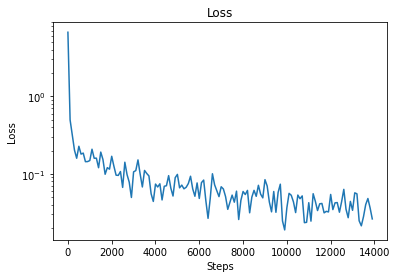

In [14]:
import matplotlib.pyplot as plt
   
steps = [i*100 for i in range(len(loss_per_10_steps))]
  
plt.plot(steps, loss_per_10_steps)
plt.title('Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

In [15]:
hop1 = pd.read_csv('../Data/Path_gen/1hop_triples.csv', sep='\\t', names=['s', 'p', 'o'], header = 0).reset_index(drop=True)

In [28]:
hop1

,s,p,o
73,m.0286f82,film.film.genre,m.02kdv5l
77,m.02rygc4,film.film.genre,m.02822
139,m.011n6yxf,film.film.genre,m.02822
147,m.0gktl2l,film.film.genre,m.02822
152,m.09n9rnk,film.film.genre,m.082gq
...,...,...,...
4732100,m.05my74d,architecture.architect.structures_designed,m.02mv8x
4732112,m.0dc5mhq,film.film.genre,m.02822
4732173,m.063z2by,organization.organization.geographic_scope,m.07ssc
4732183,m.0b681_d,film.film.genre,m.02822


In [ ]:
hop1[hop1.p == 'law.invention.date_of_invention']

In [ ]:
import pickle
with open(r"../Data/Path_gen/unseen.pkl", "rb") as f:
    unseen = pickle.load(f)

In [21]:
hop1.drop(hop1[~hop1.p.isin(unseen)].index, inplace = True)
len(hop1)

223987

In [71]:
hop1_sample = hop1.groupby('p').sample(frac=1).reset_index(drop=True).groupby('p').head(5)
len(hop1_sample)

141

In [72]:
def cleanprop(p):
    topic, sub = p.rsplit('.', 1)
    _, topic = topic.rsplit('.', 1)
    sub = sub.replace('_', ' ')
    topic = topic.replace('_', ' ')
    return topic, sub

def get_question(input_text, max_length=64):
    model.eval()
    features = tokenizer([input_text], return_tensors='pt')
    output = model.generate(input_ids=features['input_ids'].to(dev), 
               attention_mask=features['attention_mask'].to(dev),
               max_length=max_length)
    return tokenizer.decode(output[0])[6:-4]

In [73]:
model.eval()
qlines = []
for r in tqdm(hop1_sample.iterrows(), total=hop1_sample.shape[0]):
    s = r[1][0]
    p = r[1][1]
    o = r[1][2]
    if s not in mid2name or o not in mid2name:
        continue
    topic, sub = cleanprop(p)
    input_text = 'WQSP: '+ mid2name[s].lower() +' | '+ topic + ' | '+ sub + ' | '+ mid2name[o].lower()  + ' </s>'
    output_text = get_question(input_text)

    qlines.append((output_text, p))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:15<00:00,  9.06it/s]


In [ ]:
df=pd.DataFrame(qlines, columns=['QA', 'Rel']).drop_duplicates().dropna()
df.to_csv('data/1hop-synth-t5-unseen-only-medium.csv')
len(df)